In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import itertools # Importando itertools para generar combinaciones de columnas
# Importando la función seasonal_decompose para la descomposición de series temporales
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.patches as mpatches
import payments_manager as pm
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
#pm.help()
#pm.reset()
#pm.init() #debug=True)
cr_cp = pm.df('cr_cp')
fe_cp = pm.df('fe_cp')
#cr_cp.info()
#fe_cp.info()

df_jo = pm.df('df_jo')
#df_jo.info()
df_jo = pm.sort("df_jo", ["id_cr"]).reset_index()
df_jo = df_jo.drop(columns=['index'])

#df_jo = df_jo.drop(columns=['Mes_created_at'])
df_jo_cp = df_jo.copy()

df_jo_cp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32092 entries, 0 to 32091
Data columns (total 45 columns):
 #   Column                      Non-Null Count  Dtype          
---  ------                      --------------  -----          
 0   id_cr                       32092 non-null  int64          
 1   id_fe                       32092 non-null  int64          
 2   fe_cr_id                    21055 non-null  float64        
 3   user_id                     32092 non-null  int64          
 4   active                      32092 non-null  int64          
 5   created_at                  32092 non-null  datetime64[ns] 
 6   created_at_fe               21055 non-null  datetime64[ns] 
 7   amount                      32092 non-null  float64        
 8   fee                         21055 non-null  float64        
 9   stat_cr                     32092 non-null  object         
 10  stat_fe                     32092 non-null  object         
 11  transfer_type               32092 non-nul

# Con user_id

/tmp/ipykernel_171228/43690449.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_simpl['transfer_type'] = df_simpl['transfer_type'].map({'regular': 0, 'instant': 1})


transfer_type
1    19488
0    12604
Name: count, dtype: int64


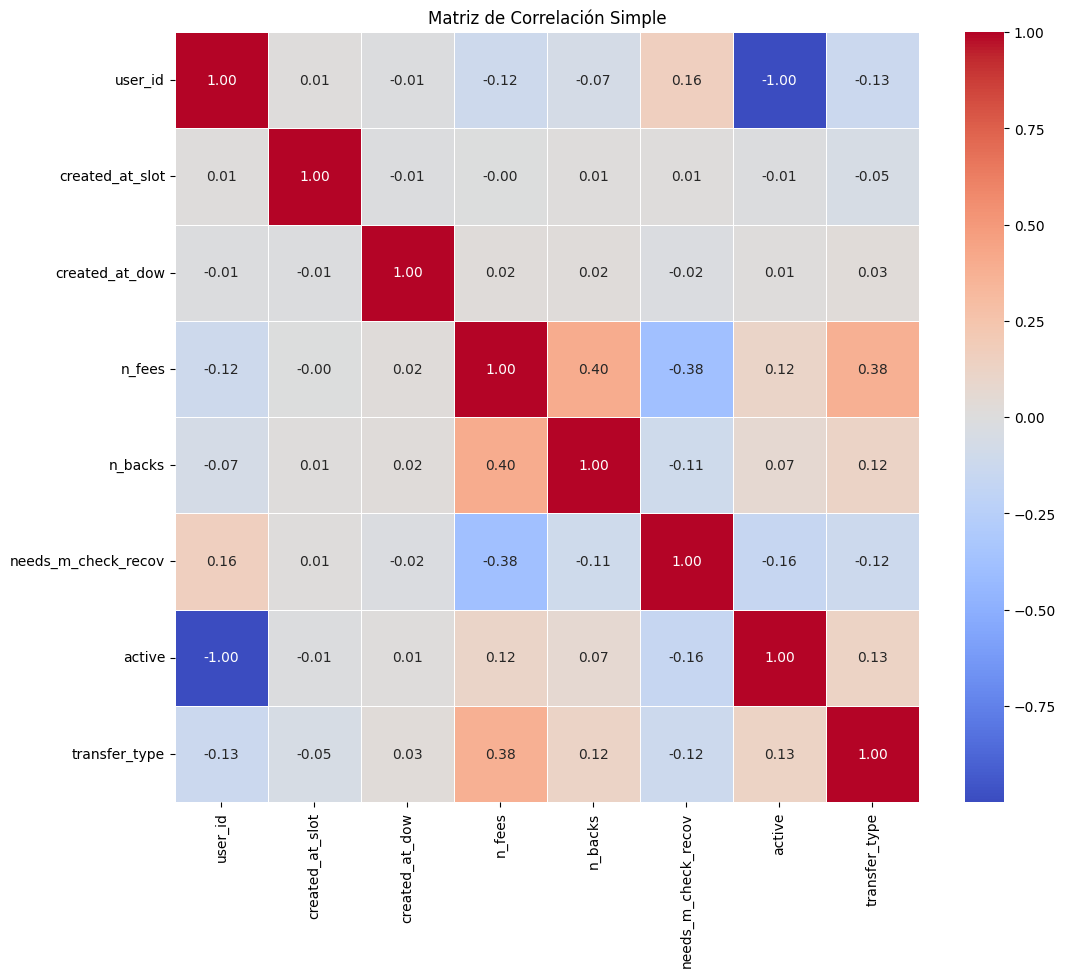

In [3]:
# Lista de columnas que deseas seleccionar
columnas_deseadas = ['user_id', 'created_at_slot', 'created_at_dow' , 'n_fees', 'n_backs', 'needs_m_check_recov', 'active', 'transfer_type']

# Crear un nuevo DataFrame con esas columnas
df_simpl = df_jo_cp[columnas_deseadas]

# Reasignar valores en la columna 'transfer_type'
df_simpl['transfer_type'] = df_simpl['transfer_type'].map({'regular': 0, 'instant': 1})

# Verificar los cambios
print(df_simpl['transfer_type'].value_counts())


# Calcular la matriz de correlación
m_corr_simpl = df_simpl.corr()

# Visualizar la matriz de correlación
plt.figure(figsize=(12, 10))
sns.heatmap(m_corr_simpl, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Matriz de Correlación Simple')
plt.show()

In [33]:
# Vamos a probar modelo de REGRESIÓN LOGÍSTICA con lo que tenemos para practicar

# Crea la matriz de características y la var objetivo
X = df_simpl.drop(columns=['needs_m_check_recov', 'active','user_id'])  # Elimina la columna 'good_user' por nombre
y = df_simpl['needs_m_check_recov']  # La columna de la variable objetivo

# Obtener los nombres de las características
feature_names = X.columns

# Divide los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=None)

# Crea el clasificador de regresión logística. El 'liblinear' usa metodo de optimización de minimos cuadrados generalizados (L2) y soporta la regularización L1 y L2
clf = LogisticRegression(solver="liblinear")

# Entrena el clasificador
clf.fit(X_train, y_train)

# Realiza predicciones sobre el conjunto de prueba
predicciones = clf.predict(X_test)

print (clf.coef_)

# Muestra las primeras 10 predicciones
#predicciones[:10]

# Genera las probabilidades de predicción
predicciones_probabilidades = clf.predict_proba(X_test)

# Muestra las primeras 10 probabilidades de predicción
#predicciones_probabilidades[:10]



[[ 0.00683793 -0.00791238 -1.06579503  0.04808074  0.27789003]]


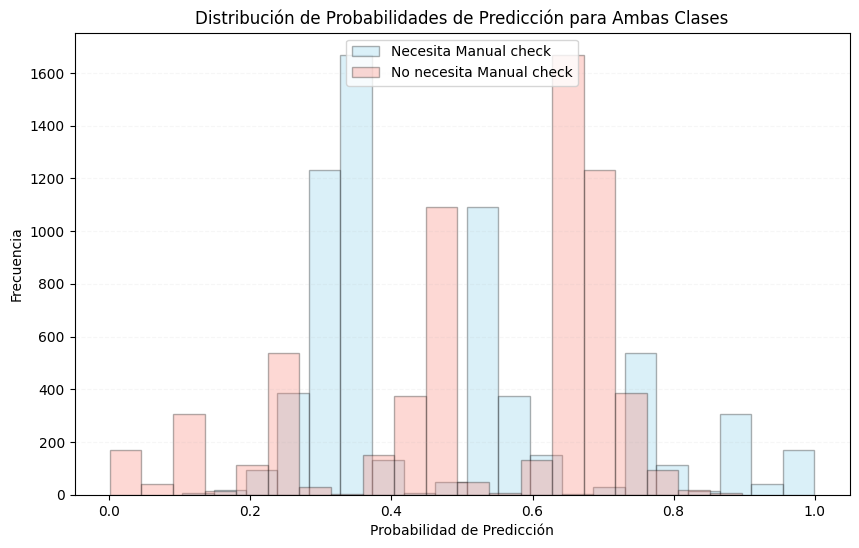

In [34]:
# Crea un histograma de las probabilidades de predicción para ambas clases
plt.figure(figsize=(10, 6)) 

# # Histograma para la clase negativa (need manual check)
plt.hist(predicciones_probabilidades[:, 0], bins=20, color="skyblue", edgecolor="black", alpha=0.3, label="Necesita Manual check")
# Histograma para la clase positiva (no need manual check)
plt.hist(predicciones_probabilidades[:, 1], bins=20, color="salmon", edgecolor="black", alpha=0.3, label="No necesita Manual check")
# Título y etiquetas de los ejes
plt.title("Distribución de Probabilidades de Predicción para Ambas Clases")
plt.xlabel("Probabilidad de Predicción")
plt.ylabel("Frecuencia")
plt.legend(loc="upper center") 
# Muestra la leyenda en el gráfico
plt.grid(axis="y", linestyle="--", alpha=0.1)
plt.show()

In [35]:
# Crea un DataFrame con las probabilidades de predicción
probs_df = pd.DataFrame(predicciones_probabilidades)

# Reinicia el índice y crea una copia de los datos de prueba
X_2 = X_test.reset_index().copy()
X_2["needs_m_check_recov"] = y_test.tolist()

# Combina los datos de prueba con las probabilidades de predicción
X_2["prediccion"] = predicciones
X_2 = pd.concat([X_2, probs_df], axis=1)

# Muestra las primeras 20 filas de comparación
X_2[["needs_m_check_recov", "prediccion", 0, 1]].head(20)

,needs_m_check_recov,prediccion,0,1
0,0,0,0.501103,0.498897
1,0,0,0.531145,0.468855
2,0,0,0.606937,0.393063
3,1,0,0.995590,0.004410
4,0,0,0.545007,0.454993
5,1,1,0.312312,0.687688
6,1,1,0.365541,0.634459
7,1,1,0.285541,0.714459
8,1,1,0.250933,0.749067
9,0,0,0.556849,0.443151


Text(70.5815972222222, 0.5, 'Realidad')

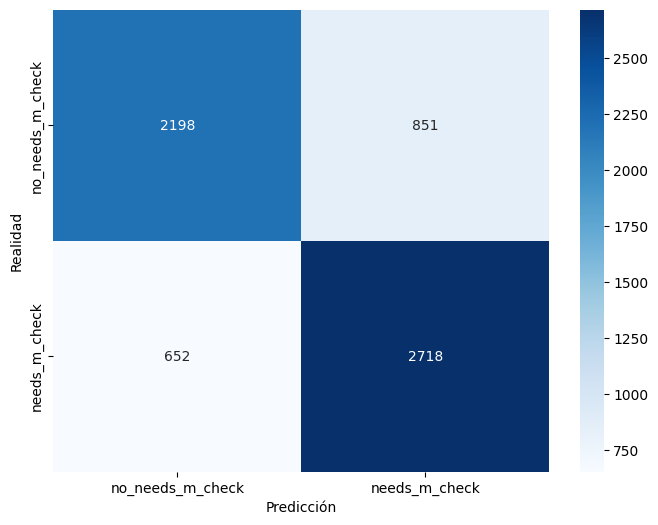

In [36]:
# Importa la función para crear la matriz de confusión
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Genera la matriz de confusión
matriz_confusion = confusion_matrix(y_test, predicciones)
columnas = ['no_needs_m_check', 'needs_m_check'] # 0 para No necesita manual check y 1 para Sí necesita manual check

# Visualiza la matriz de confusión utilizando un mapa de calor

plt.figure(figsize=(8, 6))
sns.heatmap(matriz_confusion, annot=True, fmt='d', cmap='Blues', xticklabels=columnas, yticklabels=columnas)
plt.xlabel("Predicción")
plt.ylabel("Realidad")

No vamos a usar el user_id porque sino todas necesitan manual check. 


# Ahora solo con los user_id activos pero sin usar columna user_id

In [8]:
df_simpl_1=df_simpl[df_simpl['active']==1]

df_simpl_1

,user_id,created_at_slot,created_at_dow,n_fees,n_backs,needs_m_check_recov,active,transfer_type
0,47,7,1,0,0,1,1,0
2,804,14,1,0,0,1,1,0
3,812,14,1,0,0,1,1,0
4,191,14,1,0,0,1,1,0
5,430,14,1,0,1,1,1,0
...,...,...,...,...,...,...,...,...
32087,55916,21,6,2,2,0,1,1
32088,39339,21,6,3,3,0,1,1
32089,24505,21,6,0,0,1,1,1
32090,100781,21,6,1,1,0,1,1


In [10]:
# Vamos a probar modelo de REGRESIÓN LOGÍSTICA con lo que tenemos para practicar

# Crea la matriz de características y la var objetivo
X = df_simpl_1.drop(columns=['needs_m_check_recov', 'active'])  # Elimina la columna 'good_user' por nombre
y = df_simpl_1['needs_m_check_recov']  # La columna de la variable objetivo

# Obtener los nombres de las características
feature_names = X.columns

# Divide los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=None)

# Crea el clasificador de regresión logística. El 'liblinear' usa metodo de optimización de minimos cuadrados generalizados (L2) y soporta la regularización L1 y L2
clf = LogisticRegression(solver="liblinear")

# Entrena el clasificador
clf.fit(X_train, y_train)

# Realiza predicciones sobre el conjunto de prueba
predicciones = clf.predict(X_test)

print (clf.coef_)

# Muestra las primeras 10 predicciones
#predicciones[:10]

# Genera las probabilidades de predicción
predicciones_probabilidades = clf.predict_proba(X_test)

# Muestra las primeras 10 probabilidades de predicción
#predicciones_probabilidades[:10]



[[-9.62457533e-06  2.21703709e-02  3.93505279e-02 -9.57181404e-01
   5.12694270e-02  3.27385843e-01]]


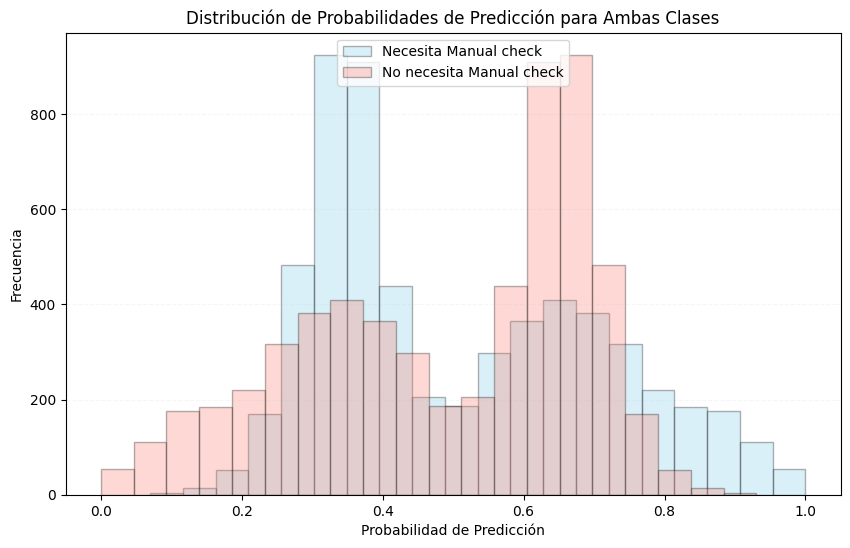

In [11]:
# Crea un histograma de las probabilidades de predicción para ambas clases
plt.figure(figsize=(10, 6)) 

# # Histograma para la clase negativa (need manual check)
plt.hist(predicciones_probabilidades[:, 0], bins=20, color="skyblue", edgecolor="black", alpha=0.3, label="Necesita Manual check")
# Histograma para la clase positiva (no need manual check)
plt.hist(predicciones_probabilidades[:, 1], bins=20, color="salmon", edgecolor="black", alpha=0.3, label="No necesita Manual check")
# Título y etiquetas de los ejes
plt.title("Distribución de Probabilidades de Predicción para Ambas Clases")
plt.xlabel("Probabilidad de Predicción")
plt.ylabel("Frecuencia")
plt.legend(loc="upper center") 
# Muestra la leyenda en el gráfico
plt.grid(axis="y", linestyle="--", alpha=0.1)
plt.show()

In [12]:
# Crea un DataFrame con las probabilidades de predicción
probs_df = pd.DataFrame(predicciones_probabilidades)

# Reinicia el índice y crea una copia de los datos de prueba
X_2 = X_test.reset_index().copy()
X_2["needs_m_check_recov"] = y_test.tolist()

# Combina los datos de prueba con las probabilidades de predicción
X_2["prediccion"] = predicciones
X_2 = pd.concat([X_2, probs_df], axis=1)

# Muestra las primeras 20 filas de comparación
X_2[["needs_m_check_recov", "prediccion", 0, 1]].head(20)

,needs_m_check_recov,prediccion,0,1
0,0,0,0.632008,0.367992
1,1,1,0.321989,0.678011
2,0,0,0.590890,0.409110
3,0,0,0.813495,0.186505
4,1,1,0.351635,0.648365
5,1,0,0.784734,0.215266
6,0,1,0.456689,0.543311
7,1,1,0.200598,0.799402
8,1,1,0.447866,0.552134
9,1,1,0.285829,0.714171


Text(70.5815972222222, 0.5, 'Realidad')

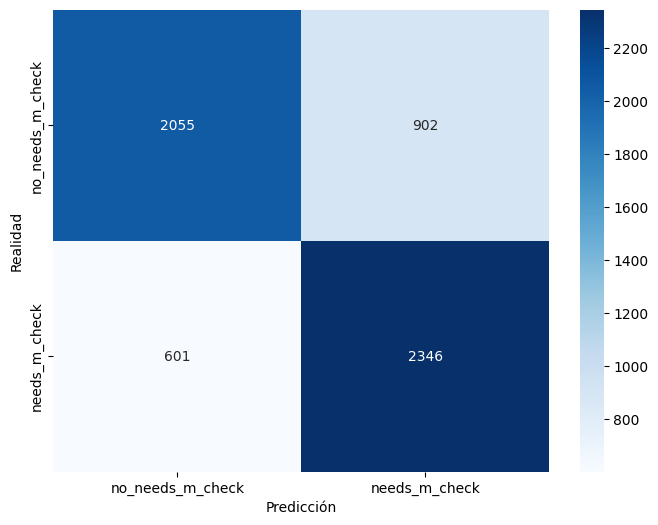

In [13]:
# Importa la función para crear la matriz de confusión
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Genera la matriz de confusión
matriz_confusion = confusion_matrix(y_test, predicciones)
columnas = ['no_needs_m_check', 'needs_m_check'] # 0 para No necesita manual check y 1 para Sí necesita manual check

# Visualiza la matriz de confusión utilizando un mapa de calor

plt.figure(figsize=(8, 6))
sns.heatmap(matriz_confusion, annot=True, fmt='d', cmap='Blues', xticklabels=columnas, yticklabels=columnas)
plt.xlabel("Predicción")
plt.ylabel("Realidad")

No hay mejora significativa con solo los activos. 

# Ahora solo con los user_id q tienen active=0

In [14]:
df_simpl_0=df_simpl[df_simpl['active']==0]

df_simpl_0.head(30)

,user_id,created_at_slot,created_at_dow,n_fees,n_backs,needs_m_check_recov,active,transfer_type
1,99001309,14,0,0,1,0,0,0
19,99004217,21,1,0,1,0,0,0
24,99000091,7,2,0,0,1,0,0
31,99000972,7,2,0,0,1,0,0
32,99003324,14,2,0,0,1,0,0
45,99010390,7,3,0,1,0,0,0
47,99000189,7,3,0,1,0,0,0
56,99003578,14,3,0,1,0,0,0
60,99000167,14,3,0,0,1,0,0
62,99000108,14,3,0,0,1,0,0


In [15]:
# Vamos a probar modelo de REGRESIÓN LOGÍSTICA con lo que tenemos para practicar

# Crea la matriz de características y la var objetivo
X = df_simpl_0.drop(columns=['needs_m_check_recov','active'])  # Elimina la columna 'good_user' por nombre
y = df_simpl_0['needs_m_check_recov']  # La columna de la variable objetivo

# Obtener los nombres de las características
feature_names = X.columns

# Divide los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=None)

# Crea el clasificador de regresión logística. El 'liblinear' usa metodo de optimización de minimos cuadrados generalizados (L2) y soporta la regularización L1 y L2
clf = LogisticRegression(solver="liblinear")

# Entrena el clasificador
clf.fit(X_train, y_train)

# Realiza predicciones sobre el conjunto de prueba
predicciones = clf.predict(X_test)

print (clf.coef_)

# Muestra las primeras 10 predicciones
#predicciones[:10]

# Genera las probabilidades de predicción
predicciones_probabilidades = clf.predict_proba(X_test)

# Muestra las primeras 10 probabilidades de predicción
#predicciones_probabilidades[:10]


[[ 1.25765601e-08  1.68270009e-15  3.13599724e-16 -1.18532725e-16
  -3.81605477e-17  4.50077339e-17]]


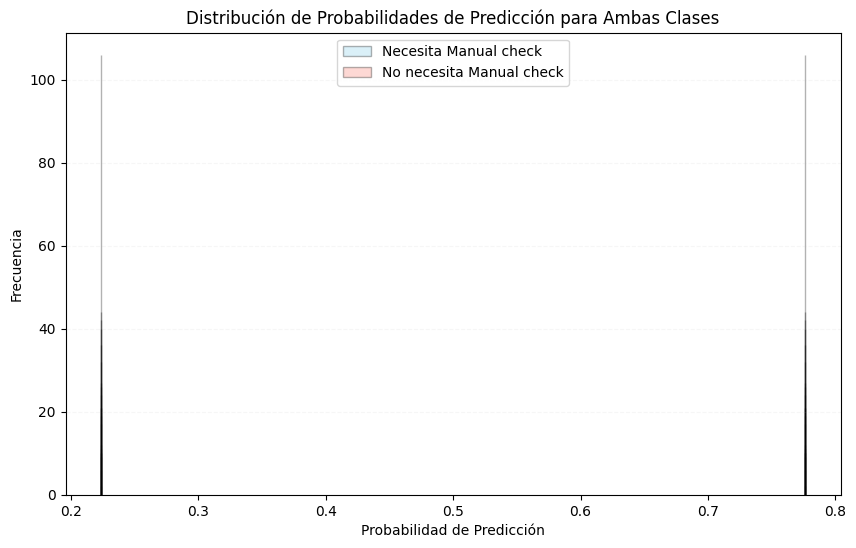

In [16]:
# Crea un histograma de las probabilidades de predicción para ambas clases
plt.figure(figsize=(10, 6)) 

# # Histograma para la clase negativa (need manual check)
plt.hist(predicciones_probabilidades[:, 0], bins=20, color="skyblue", edgecolor="black", alpha=0.3, label="Necesita Manual check")
# Histograma para la clase positiva (no need manual check)
plt.hist(predicciones_probabilidades[:, 1], bins=20, color="salmon", edgecolor="black", alpha=0.3, label="No necesita Manual check")
# Título y etiquetas de los ejes
plt.title("Distribución de Probabilidades de Predicción para Ambas Clases")
plt.xlabel("Probabilidad de Predicción")
plt.ylabel("Frecuencia")
plt.legend(loc="upper center") 
# Muestra la leyenda en el gráfico
plt.grid(axis="y", linestyle="--", alpha=0.1)
plt.show()

In [17]:
# Crea un DataFrame con las probabilidades de predicción
probs_df = pd.DataFrame(predicciones_probabilidades)

# Reinicia el índice y crea una copia de los datos de prueba
X_3 = X_test.reset_index().copy()
X_3["needs_m_check_recov"] = y_test.tolist()

# Combina los datos de prueba con las probabilidades de predicción
X_3["prediccion"] = predicciones
X_3 = pd.concat([X_3, probs_df], axis=1)

# Muestra las primeras 20 filas de comparación
X_3[["needs_m_check_recov", "prediccion", 0, 1]].head(20)

,needs_m_check_recov,prediccion,0,1
0,1,1,0.223541,0.776459
1,1,1,0.223547,0.776453
2,1,1,0.223543,0.776457
3,1,1,0.223543,0.776457
4,0,1,0.223517,0.776483
5,1,1,0.223504,0.776496
6,1,1,0.223546,0.776454
7,0,1,0.223542,0.776458
8,0,1,0.223495,0.776505
9,0,1,0.223529,0.776471


Text(70.5815972222222, 0.5, 'Realidad')

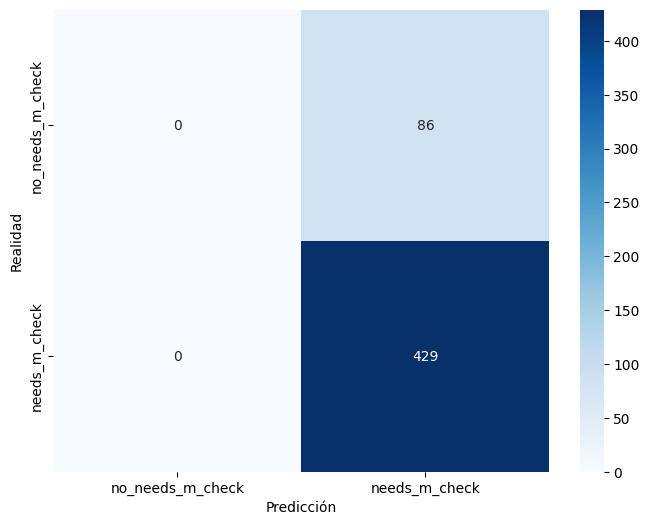

In [18]:
# Importa la función para crear la matriz de confusión
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Genera la matriz de confusión
matriz_confusion = confusion_matrix(y_test, predicciones)
columnas = ['no_needs_m_check', 'needs_m_check'] # 0 para No necesita manual check y 1 para Sí necesita manual check

# Visualiza la matriz de confusión utilizando un mapa de calor

plt.figure(figsize=(8, 6))
sns.heatmap(matriz_confusion, annot=True, fmt='d', cmap='Blues', xticklabels=columnas, yticklabels=columnas)
plt.xlabel("Predicción")
plt.ylabel("Realidad")

Con solo los deleted no vamos a ningún lugar. Todos necesitarían manual_check.

# Ahora con todos los user_id (active y no active) pero dividimos entre las cr que fueron Instant y las q fueron Regular

In [19]:
df_simpl_I=df_simpl[df_simpl['transfer_type']==1]

df_simpl_I

,user_id,created_at_slot,created_at_dow,n_fees,n_backs,needs_m_check_recov,active,transfer_type
7097,99018281,14,1,0,2,0,0,1
8432,33244,14,2,1,1,0,1,1
8433,33244,14,2,0,2,1,1,1
8772,11588,7,3,0,2,0,1,1
8781,31751,7,3,0,1,0,1,1
...,...,...,...,...,...,...,...,...
32087,55916,21,6,2,2,0,1,1
32088,39339,21,6,3,3,0,1,1
32089,24505,21,6,0,0,1,1,1
32090,100781,21,6,1,1,0,1,1


In [24]:
# Vamos a probar modelo de REGRESIÓN LOGÍSTICA con lo que tenemos para practicar

# Crea la matriz de características y la var objetivo
X = df_simpl_I.drop(columns=['needs_m_check_recov', 'active','user_id','transfer_type'])  # Elimina la columna 'good_user' por nombre
y = df_simpl_I['needs_m_check_recov']  # La columna de la variable objetivo

# Obtener los nombres de las características
feature_names = X.columns

# Divide los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=None)

# Crea el clasificador de regresión logística. El 'liblinear' usa metodo de optimización de minimos cuadrados generalizados (L2) y soporta la regularización L1 y L2
clf = LogisticRegression(solver="liblinear")

# Entrena el clasificador
clf.fit(X_train, y_train)

# Realiza predicciones sobre el conjunto de prueba
predicciones = clf.predict(X_test)

print (clf.coef_)

# Muestra las primeras 10 predicciones
#predicciones[:10]

# Genera las probabilidades de predicción
predicciones_probabilidades = clf.predict_proba(X_test)

# Muestra las primeras 10 probabilidades de predicción
#predicciones_probabilidades[:10]

[[ 0.00669903 -0.00383295 -1.79898255  0.31069092]]


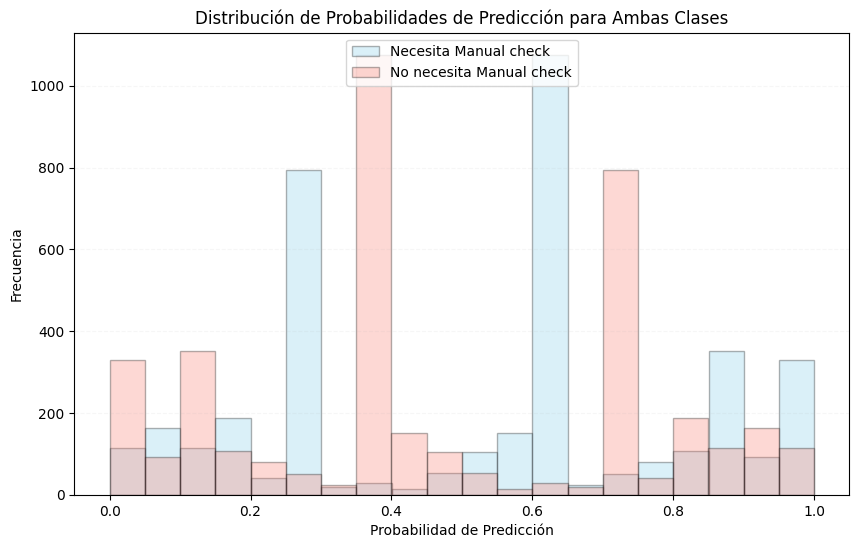

In [25]:
# Crea un histograma de las probabilidades de predicción para ambas clases
plt.figure(figsize=(10, 6)) 

# # Histograma para la clase negativa (need manual check)
plt.hist(predicciones_probabilidades[:, 0], bins=20, color="skyblue", edgecolor="black", alpha=0.3, label="Necesita Manual check")
# Histograma para la clase positiva (no need manual check)
plt.hist(predicciones_probabilidades[:, 1], bins=20, color="salmon", edgecolor="black", alpha=0.3, label="No necesita Manual check")
# Título y etiquetas de los ejes
plt.title("Distribución de Probabilidades de Predicción para Ambas Clases")
plt.xlabel("Probabilidad de Predicción")
plt.ylabel("Frecuencia")
plt.legend(loc="upper center") 
# Muestra la leyenda en el gráfico
plt.grid(axis="y", linestyle="--", alpha=0.1)
plt.show()

In [26]:
# Crea un DataFrame con las probabilidades de predicción
probs_df = pd.DataFrame(predicciones_probabilidades)

# Reinicia el índice y crea una copia de los datos de prueba
X_4 = X_test.reset_index().copy()
X_4["needs_m_check_recov"] = y_test.tolist()

# Combina los datos de prueba con las probabilidades de predicción
X_4["prediccion"] = predicciones
X_4 = pd.concat([X_4, probs_df], axis=1)

# Muestra las primeras 20 filas de comparación
X_4[["needs_m_check_recov", "prediccion", 0, 1]].head(20)

,needs_m_check_recov,prediccion,0,1
0,1,1,0.259900,0.740100
1,0,0,0.868854,0.131146
2,0,0,0.606861,0.393139
3,0,0,0.877950,0.122050
4,1,0,0.874947,0.125053
5,0,0,0.623406,0.376594
6,0,1,0.453325,0.546675
7,0,1,0.311462,0.688538
8,1,1,0.260638,0.739362
9,1,1,0.053780,0.946220


Text(70.5815972222222, 0.5, 'Realidad')

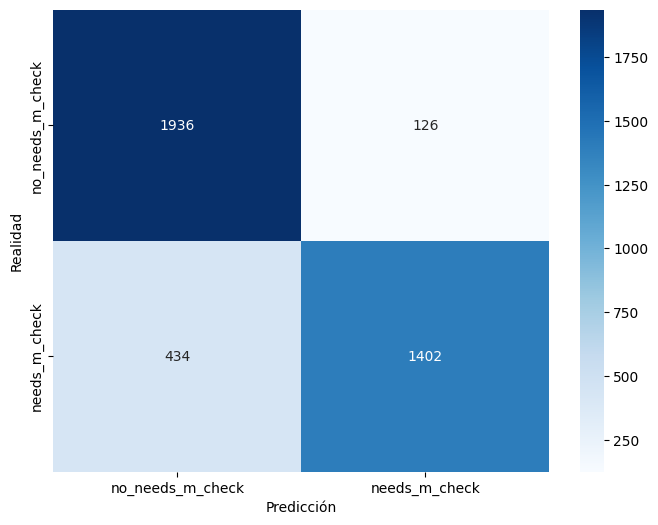

In [27]:
# Importa la función para crear la matriz de confusión
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Genera la matriz de confusión
matriz_confusion = confusion_matrix(y_test, predicciones)
columnas = ['no_needs_m_check', 'needs_m_check'] # 0 para No necesita manual check y 1 para Sí necesita manual check

# Visualiza la matriz de confusión utilizando un mapa de calor

plt.figure(figsize=(8, 6))
sns.heatmap(matriz_confusion, annot=True, fmt='d', cmap='Blues', xticklabels=columnas, yticklabels=columnas)
plt.xlabel("Predicción")
plt.ylabel("Realidad")

Mejora levemente quizás.

# Ahora solo con Regular

In [28]:
df_simpl_R=df_simpl[df_simpl['transfer_type']==0]

df_simpl_R

,user_id,created_at_slot,created_at_dow,n_fees,n_backs,needs_m_check_recov,active,transfer_type
0,47,7,1,0,0,1,1,0
1,99001309,14,0,0,1,0,0,0
2,804,14,1,0,0,1,1,0
3,812,14,1,0,0,1,1,0
4,191,14,1,0,0,1,1,0
...,...,...,...,...,...,...,...,...
31999,83792,7,6,0,1,0,1,0
32012,102720,7,6,0,0,1,1,0
32060,38250,14,6,0,3,0,1,0
32066,64005,14,6,0,1,0,1,0


In [29]:
# Vamos a probar modelo de REGRESIÓN LOGÍSTICA con lo que tenemos para practicar

# Crea la matriz de características y la var objetivo
X = df_simpl_R.drop(columns=['needs_m_check_recov', 'active','user_id','transfer_type'])  # Elimina la columna 'good_user' por nombre
y = df_simpl_R['needs_m_check_recov']  # La columna de la variable objetivo

# Obtener los nombres de las características
feature_names = X.columns

# Divide los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=None)

# Crea el clasificador de regresión logística. El 'liblinear' usa metodo de optimización de minimos cuadrados generalizados (L2) y soporta la regularización L1 y L2
clf = LogisticRegression(solver="liblinear")

# Entrena el clasificador
clf.fit(X_train, y_train)

# Realiza predicciones sobre el conjunto de prueba
predicciones = clf.predict(X_test)

print (clf.coef_)

# Muestra las primeras 10 predicciones
#predicciones[:10]

# Genera las probabilidades de predicción
predicciones_probabilidades = clf.predict_proba(X_test)

# Muestra las primeras 10 probabilidades de predicción
#predicciones_probabilidades[:10]

[[ 0.00742411 -0.0155493   0.04443131 -0.17795976]]


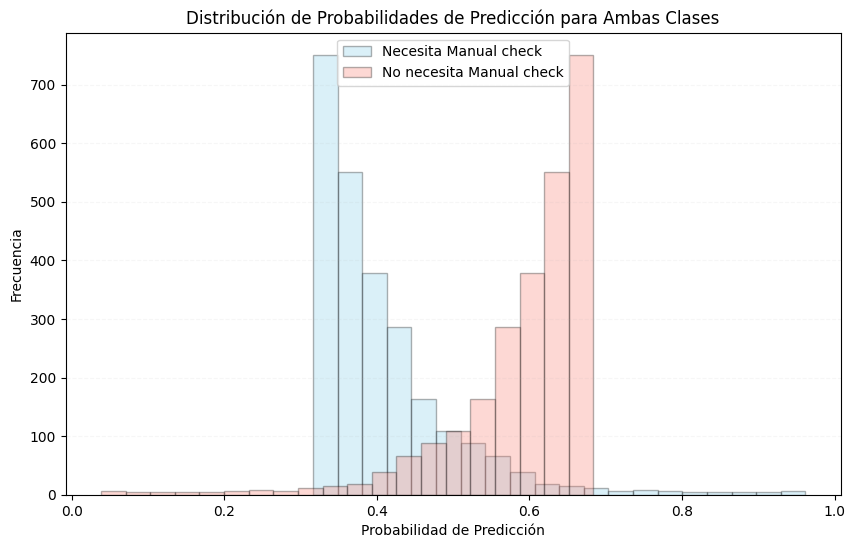

In [30]:
# Crea un histograma de las probabilidades de predicción para ambas clases
plt.figure(figsize=(10, 6)) 

# # Histograma para la clase negativa (need manual check)
plt.hist(predicciones_probabilidades[:, 0], bins=20, color="skyblue", edgecolor="black", alpha=0.3, label="Necesita Manual check")
# Histograma para la clase positiva (no need manual check)
plt.hist(predicciones_probabilidades[:, 1], bins=20, color="salmon", edgecolor="black", alpha=0.3, label="No necesita Manual check")
# Título y etiquetas de los ejes
plt.title("Distribución de Probabilidades de Predicción para Ambas Clases")
plt.xlabel("Probabilidad de Predicción")
plt.ylabel("Frecuencia")
plt.legend(loc="upper center") 
# Muestra la leyenda en el gráfico
plt.grid(axis="y", linestyle="--", alpha=0.1)
plt.show()

In [31]:
# Crea un DataFrame con las probabilidades de predicción
probs_df = pd.DataFrame(predicciones_probabilidades)

# Reinicia el índice y crea una copia de los datos de prueba
X_5 = X_test.reset_index().copy()
X_5["needs_m_check_recov"] = y_test.tolist()

# Combina los datos de prueba con las probabilidades de predicción
X_5["prediccion"] = predicciones
X_5 = pd.concat([X_5, probs_df], axis=1)

# Muestra las primeras 20 filas de comparación
X_5[["needs_m_check_recov", "prediccion", 0, 1]].head(20)

,needs_m_check_recov,prediccion,0,1
0,0,1,0.364716,0.635284
1,1,0,0.544557,0.455443
2,1,1,0.330920,0.669080
3,0,1,0.383646,0.616354
4,1,1,0.371434,0.628566
5,1,1,0.476916,0.523084
6,1,1,0.401294,0.598706
7,0,1,0.391026,0.608974
8,1,1,0.329742,0.670258
9,1,1,0.434125,0.565875


Text(70.5815972222222, 0.5, 'Realidad')

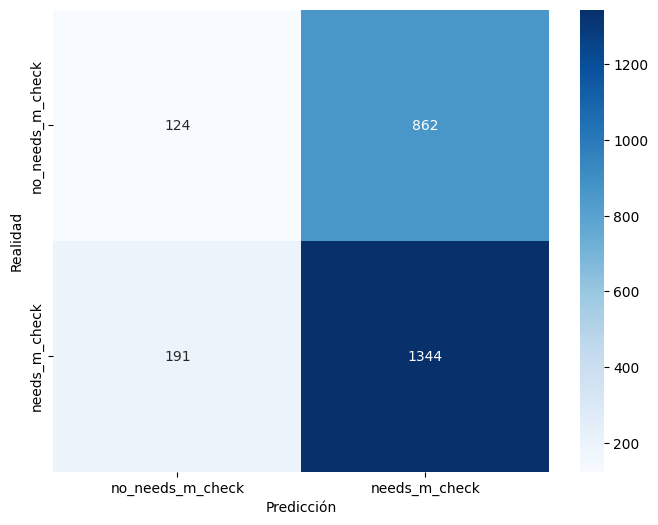

In [32]:
# Importa la función para crear la matriz de confusión
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Genera la matriz de confusión
matriz_confusion = confusion_matrix(y_test, predicciones)
columnas = ['no_needs_m_check', 'needs_m_check'] # 0 para No necesita manual check y 1 para Sí necesita manual check

# Visualiza la matriz de confusión utilizando un mapa de calor

plt.figure(figsize=(8, 6))
sns.heatmap(matriz_confusion, annot=True, fmt='d', cmap='Blues', xticklabels=columnas, yticklabels=columnas)
plt.xlabel("Predicción")
plt.ylabel("Realidad")

Las reguare solas no funcionan bien. 